In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import ujson
import os
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
import seaborn as sns

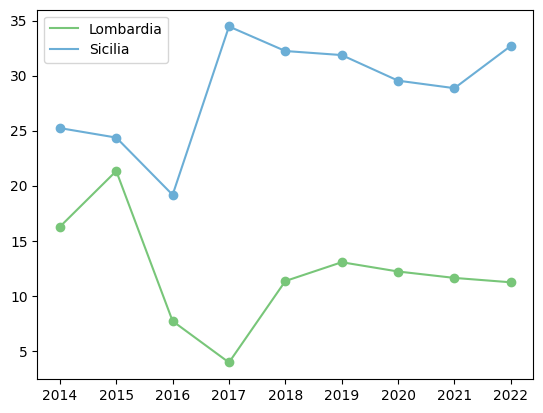

In [2]:
df = pd.read_csv('Dataset/dataset_all_2.csv')
df_ping = df[(df.Tipo == "Ping") & (df.Anno == 2022)].reset_index()
df_ping2 = df[(df.Tipo == "Ping")].reset_index()

m = []
for i in range(0, len(df_ping2)):
    m.append(float(re.findall("[-+]?(?:\d*\,*\d+)", df_ping2.iloc[i].Media)[0].replace(',','.')))
df_ping2["media_f"] = m

df_ping2 = df_ping2.drop(["Unnamed: 0","Profilo","Velocità (down/up)","Operatore","Periodo","Tipo","Media","Dev. Std.","Min","Max","TP%","Misure"],axis = 1)

df_ping3 = df_ping2[df_ping2['Territorio'] == 'Lombardia']
df_ping4 = df_ping2[df_ping2['Territorio'] == 'Sicilia']

df_ping3 = df_ping3.groupby("Anno")['media_f'].mean().reset_index()
df_ping4 = df_ping4.groupby("Anno")['media_f'].mean().reset_index()

plt.plot(df_ping3['Anno'], df_ping3['media_f'], color = '#78c679',label='Lombardia')
plt.scatter(df_ping3['Anno'], df_ping3['media_f'], color = '#78c679')
plt.plot(df_ping4['Anno'], df_ping4['media_f'], color = '#6baed6',label='Sicilia')
plt.scatter(df_ping4['Anno'], df_ping4['media_f'], color = '#6baed6')

plt.legend()
plt.show()

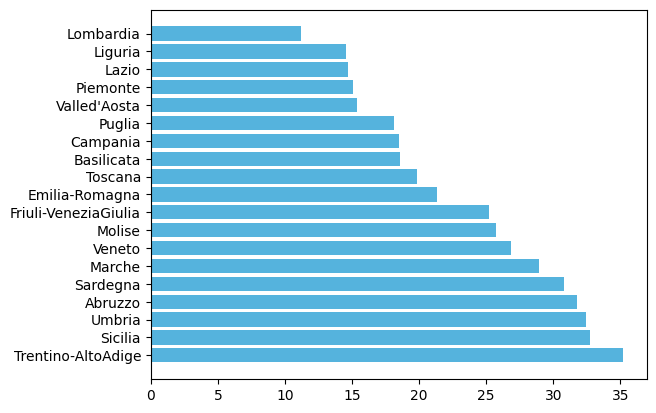

In [3]:
m = []
for i in range(0, len(df_ping)):
    m.append(float(re.findall("[-+]?(?:\d*\,*\d+)", df_ping.iloc[i].Media)[0].replace(',','.')))
df_ping["media_f"] = m
df_ping = df_ping.drop(["Unnamed: 0","Profilo","Velocità (down/up)","Operatore","Periodo","Tipo","Media","Dev. Std.","Min","Max","TP%","Misure"],axis = 1)
df_ping = df_ping.groupby(["Territorio","Anno"]).mean().reset_index()
df_ping = df_ping.sort_values(by = ['media_f'], ascending = False)
plt.barh(df_ping['Territorio'], df_ping['media_f'], color = '#55B3DD')
plt.show()

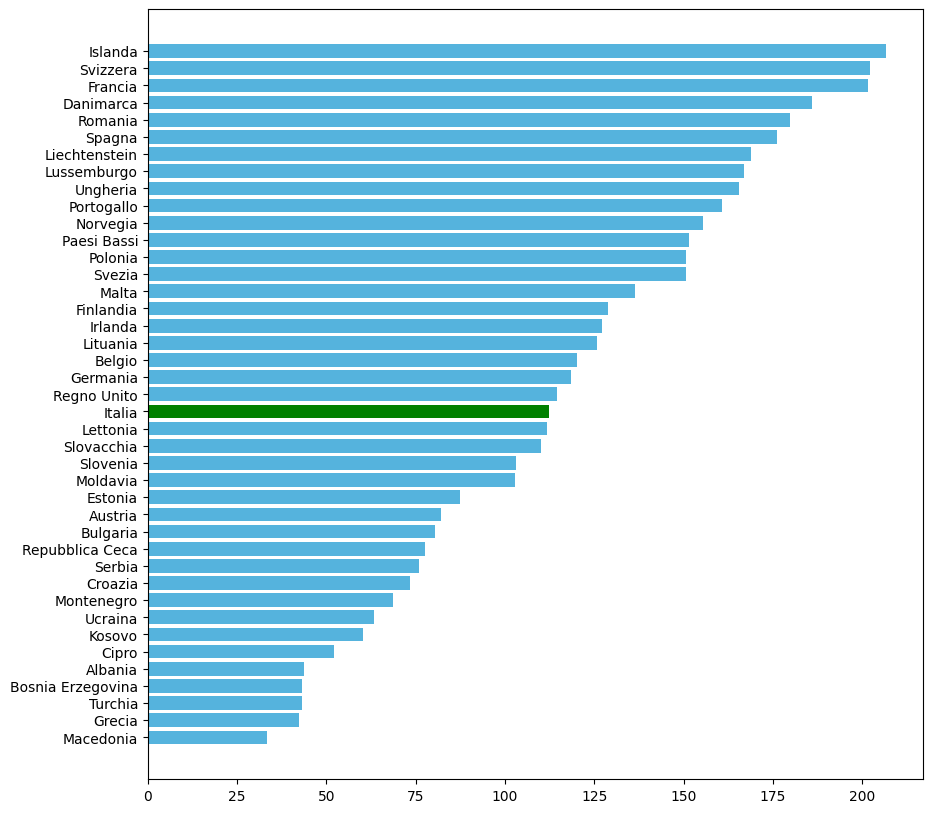

In [4]:
df2 = pd.read_csv('Dataset/europa.csv')
df2 = df2.sort_values(by=['avg_d'], ascending=True)

# Trova l'indice dell'Italia
italia_index = df2[df2['nome'] == 'Italia'].index[0]

# Dividi il DataFrame in tre parti: inferiore, Italia, superiore
df_lower = df2.iloc[:italia_index]
df_italia = df2.iloc[italia_index:italia_index + 1]
df_upper = df2.iloc[italia_index + 1:]

fig, ax = plt.subplots(1, figsize=(10, 10))

# Barre per i paesi inferiori
plt.barh(df_lower['nome'], df_lower['avg_d'], color='#55B3DD', height=0.8)

# Barra per l'Italia (colorata in modo diverso, ad esempio rosso)
plt.barh(df_italia['nome'], df_italia['avg_d'], color='green', height=0.8)

# Barre per i paesi superiori
plt.barh(df_upper['nome'], df_upper['avg_d'], color='#55B3DD', height=0.8)

plt.show()

In [5]:
directory_comuni = os.getcwd()+"/comuni"
directory_regioni = os.getcwd()+"/regioni"


def getDataset (directory):
    data = []
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            try:
                with open(os.path.join(directory,filename)) as file:
                    data.append(ujson.load(file))
            except:
                pass
        return data

dataset_comuni = pd.json_normalize(getDataset(directory_comuni))
dataset_regioni = pd.json_normalize(getDataset(directory_regioni))
dataset_comuni.rename(columns={"region_id": "COD_REG"}, inplace=True)
dataset_regioni.rename(columns={"region_id": "COD_REG"}, inplace=True)
dataset_regioni = dataset_regioni.replace(["Trentino-Alto Adige Trento"], 'Trentino' )
dataset_regioni = dataset_regioni.replace(["Trentino-Alto Adige Bolzano"], 'Trentino' )


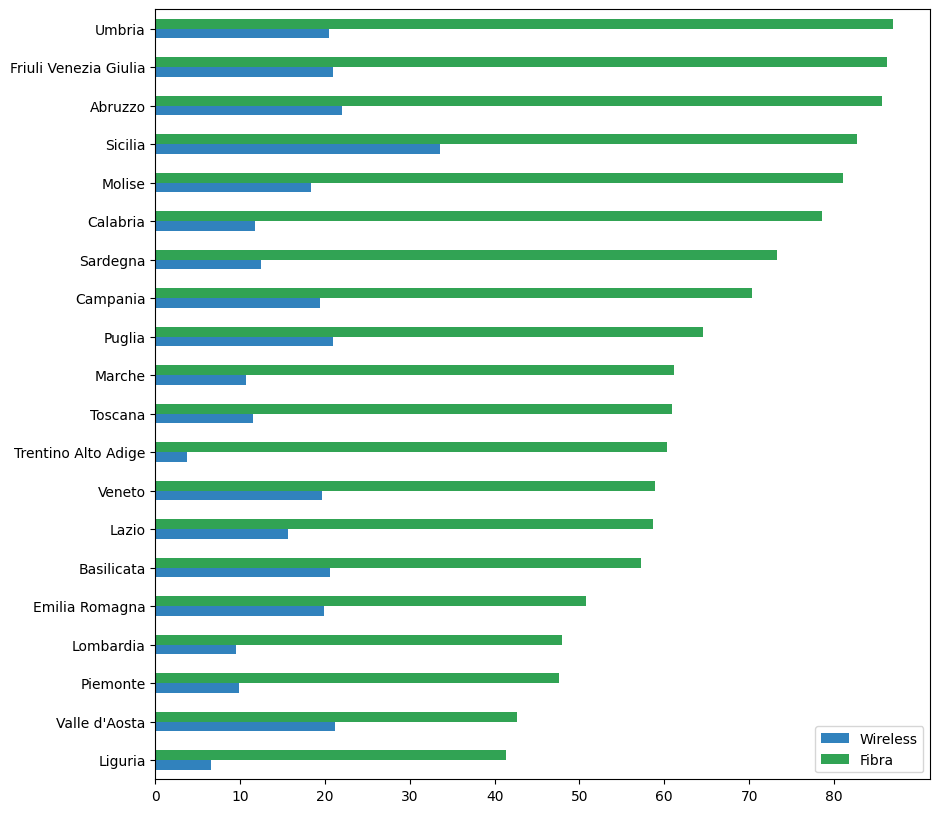

In [6]:

dfn = dataset_regioni[['region_name', 'work_progress.mean_status.wireless','work_progress.mean_status.fiber']].copy().reset_index()
dfn.set_index('region_name', inplace=True)
dfn = dfn.rename(index={'Trentino Alto Adige-Trento': 'Trentino Alto Adige'})
dfn=dfn.drop('Trentino Alto Adige-Bolzano')
dfn = dfn.drop('index', axis=1)
dfn = dfn.sort_values(by='work_progress.mean_status.fiber', ascending=True)
ax = dfn.plot.barh( color=['#3182bd','#31a354'],legend=False,figsize=(10, 10))
custom_ticks = [0,10, 20,30, 40,50, 60,70, 80] 
ax.set_xticks(custom_ticks)
ax.legend(labels=['Wireless', 'Fibra'])
plt.ylabel('') 
plt.show()

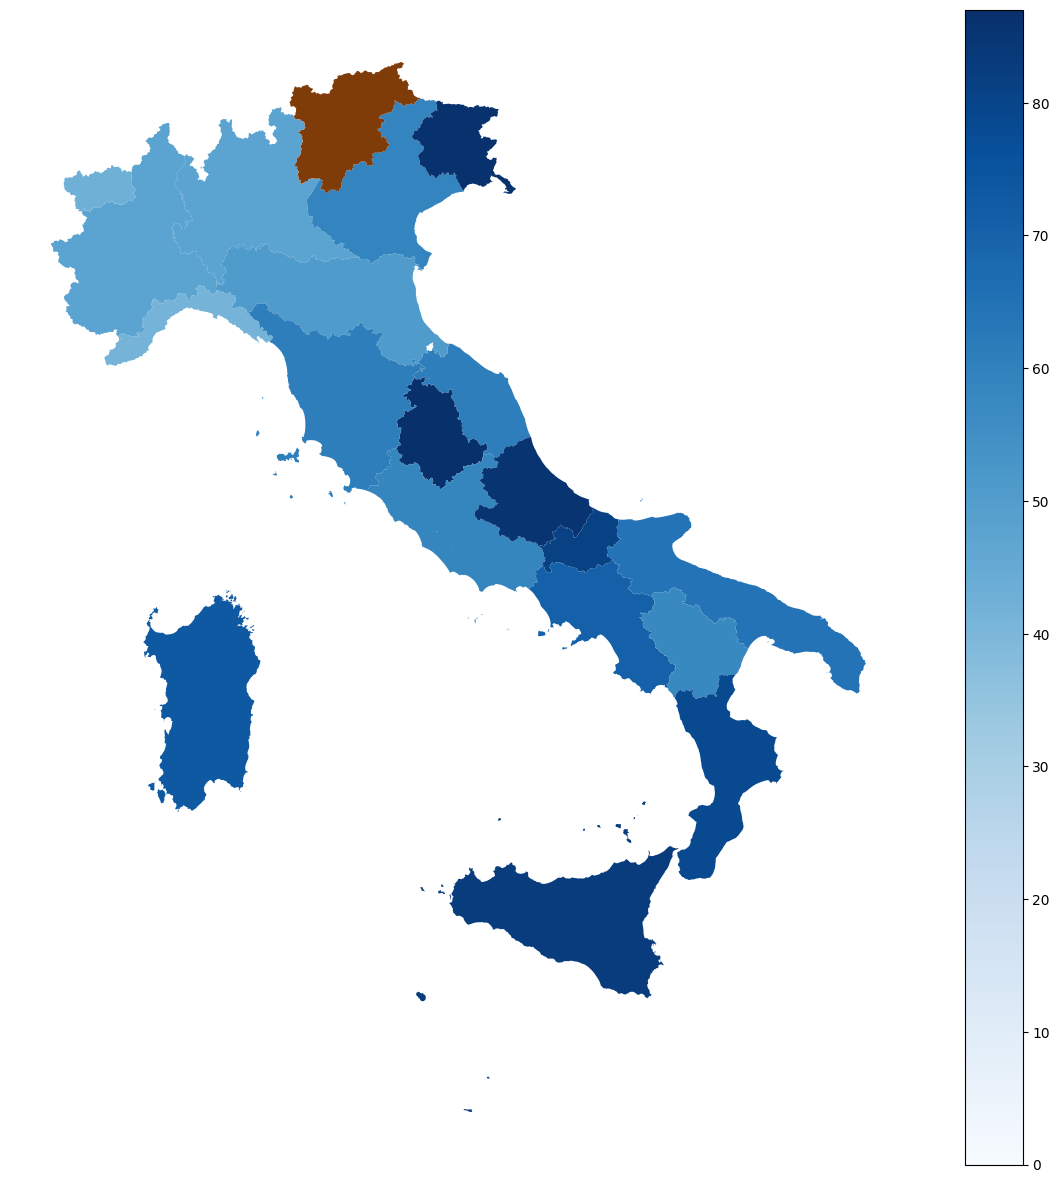

In [7]:
italy = gpd.read_file('heatmap_velocita_anni/reg2011_g.shp')
new_regions = pd.read_csv('heatmap_velocita_anni/reg2011_g.csv')
covid = pd.read_csv('heatmap_velocita_anni/Covid.csv')
italy['NOME_REG'] = new_regions['NOME_REG']
merge = italy.merge(covid, on='NOME_REG', how='left')
merge2 = italy.merge(dataset_regioni, on='COD_REG', how='right')
fig, ax = plt.subplots(1, figsize=(15, 15),facecolor='white')
col = 'work_progress.mean_status.fiber'
merge.loc[3,'work_progress.mean_status.fiber'] = 100

merge2.plot(ax=ax,
           column=col,
           cmap='Blues',
           legend=True,
           categorical=False)
merge[merge.NOME_REG == 'Trentino'].plot(
        ax=ax,
        column=col,
        cmap='PuOr',
        label='ciao',
        legend=False,
        categorical=True
    )
ax.set_axis_off()
plt.show()

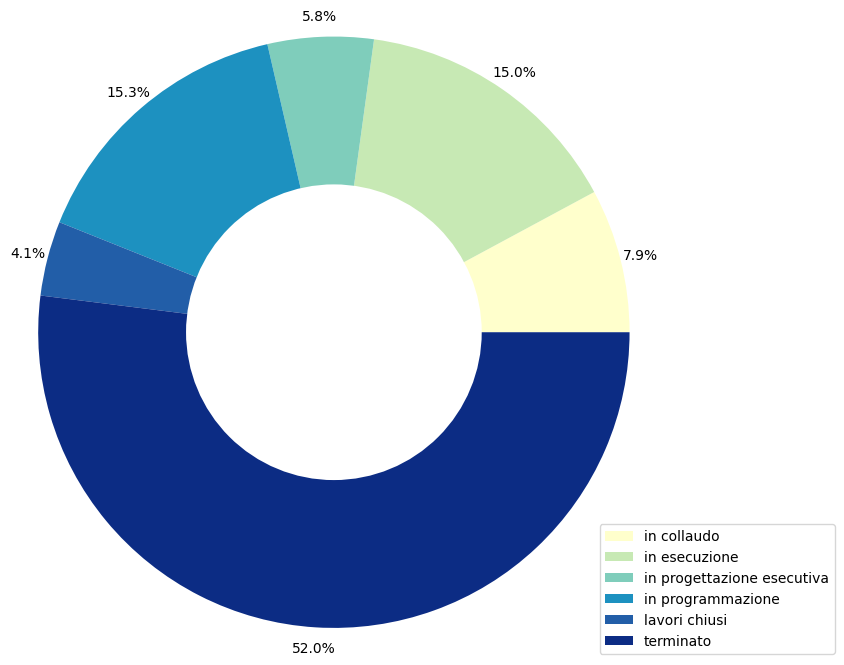

In [8]:
fiber_status = dataset_comuni.groupby(["work_progress.fiber.status"]).size()
colors = ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4','#1d91c0','#225ea8','#0c2c84']
custom_cmap = ListedColormap(colors)
fiber_status[3]=fiber_status[2]+fiber_status[3]
fiber_status.drop('in progettazione definitiva', inplace=True)
fig, ax = plt.subplots(facecolor='white')
fiber_status.plot.pie(autopct="%1.1f%%", radius=2,labeldistance=None,pctdistance=1.07,colormap=custom_cmap)
plt.legend(loc=2,bbox_to_anchor=(1.2, 0))

centre_circle = plt.Circle((0, 0), 1, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()


/tmp/ipykernel_17177/1401656903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_download_media["media_f"] = m


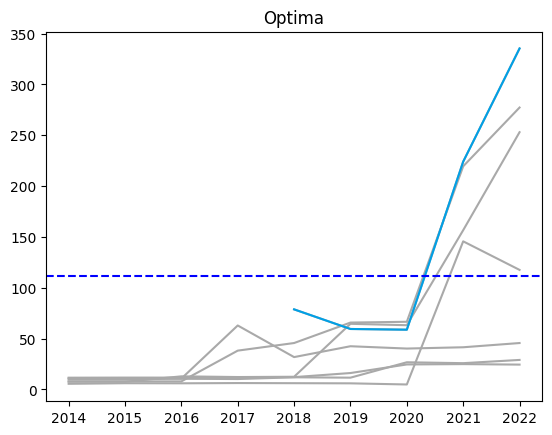

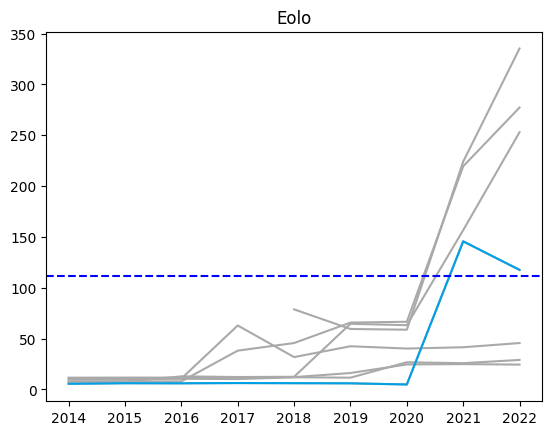

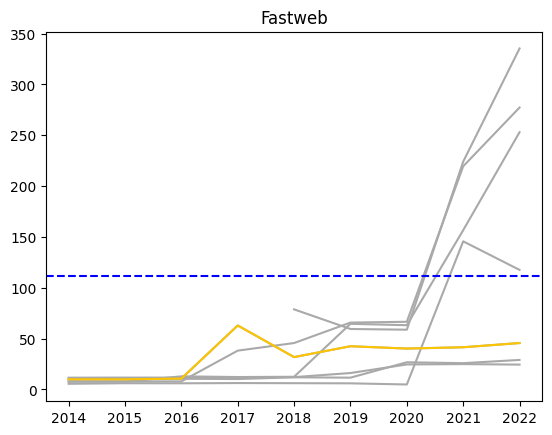

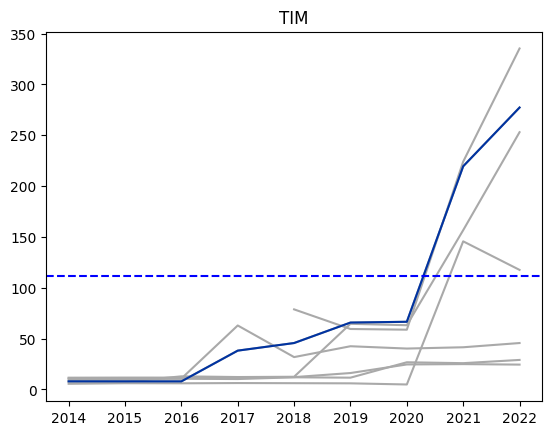

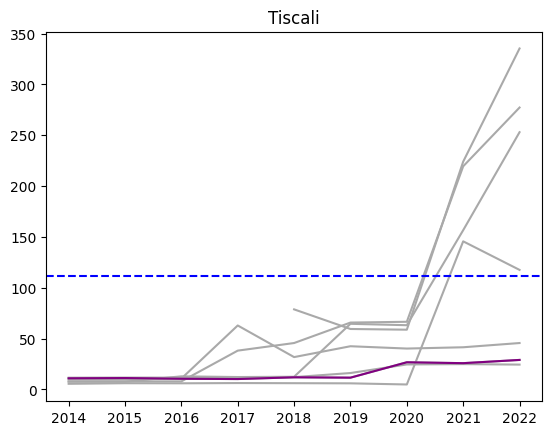

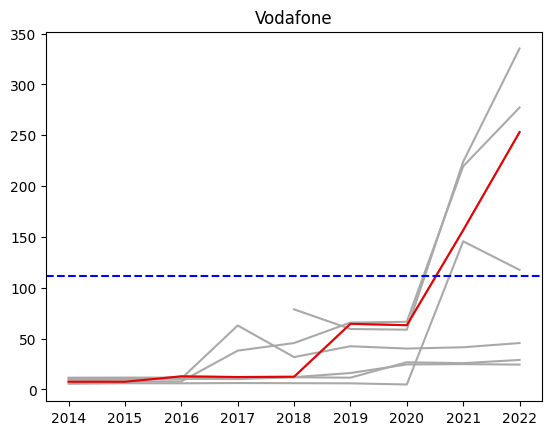

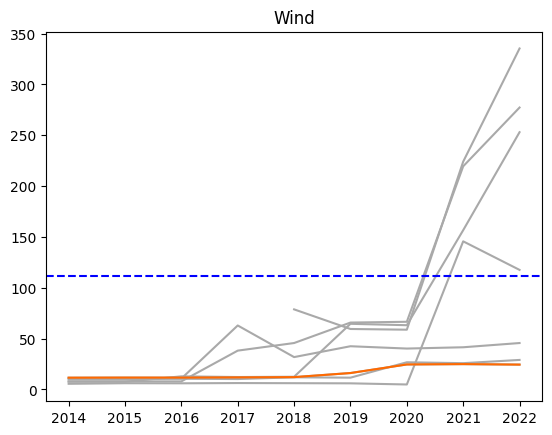

<Figure size 640x480 with 0 Axes>

In [9]:
df = pd.read_csv('Dataset/dataset.csv')
df_download_media = df[(df.Tipo == "Download")]
m = []
for i in range(0, len(df_download_media)):
    m.append(float(re.findall("[-+]?(?:\d*\,*\d+)", df_download_media.iloc[i].Media)[0].replace(',','.')))
df_download_media["media_f"] = m
df_download_media = df_download_media.drop(["Unnamed: 0","Profilo","Velocità (down/up)","Territorio","Periodo","Tipo","Media","Dev. Std.","Min","Max","TP%","Misure"],axis = 1)
df_download_media = df_download_media.groupby(["Operatore","Anno"]).mean().reset_index()
anni = np.sort(df_download_media.Anno.unique())
operatori = ['Optima','Eolo','Fastweb','TIM','Tiscali','Vodafone','Wind']
colors = ['#00a0e6','#00a0e6','#fdc400','#0033a1','purple','#e60000','#ff6900']
backgroundcolor = 'white'
not_highlighted_color = 'darkgrey'
sns.set_style(rc = {'axes.facecolor': backgroundcolor})
soglia = 500;
for op in range(0,len(operatori)):
    operatore_velocita = []
    
    for operatore in operatori:
        plt.title(operatori[op])
        velocita = []
        for anno in anni:
     
            media_anno = df_download_media[(df_download_media.Operatore == operatore) & (df_download_media.Anno == anno)].media_f.values
            if len(media_anno) == 0:
                velocita.append(np.nan)
            else:
                if media_anno[0] > soglia:
                    velocita.append(np.nan)
                else:
                    velocita.append(media_anno[0])
   
        if(operatore == operatori[op]):
            operatore_velocita = velocita
    
        myplot = sns.lineplot(x = anni, y = velocita, color = not_highlighted_color)
    mypolt = sns.lineplot(x = anni, y = operatore_velocita, color = colors[op])
    
    fig = myplot.get_figure()
    plt.axhline(y=112, color='blue', linestyle='--', label='Media Italiana')
    
    fig.savefig("out" + operatori[op] +".png")
    plt.show()
    plt.clf()


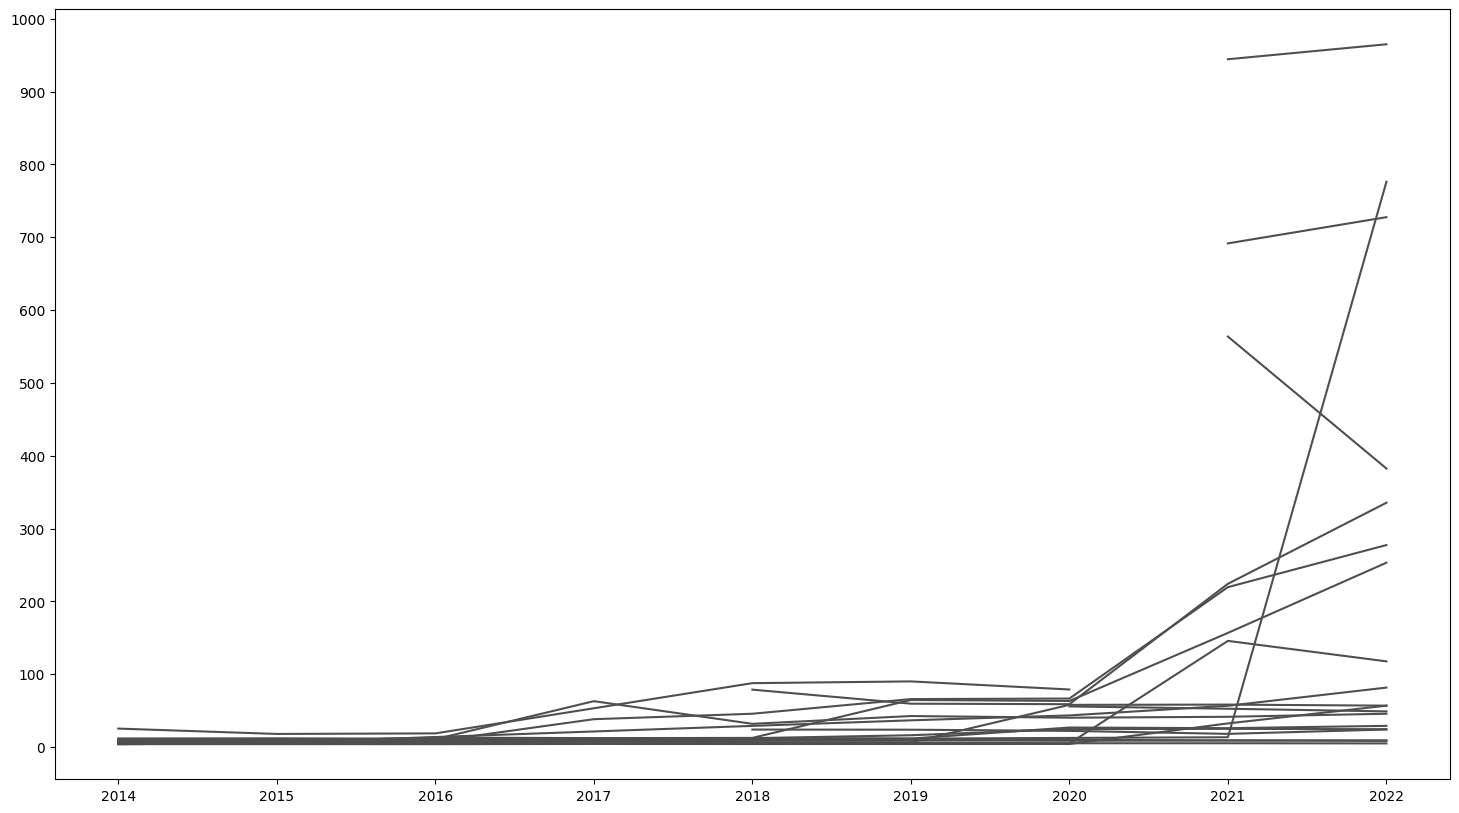

In [10]:
fig, ax = plt.subplots(1, figsize=(18, 10))
anni = np.sort(df_download_media.Anno.unique())
tim_velocita = []
for operatore in df_download_media.Operatore.unique():
    velocita = []
    for anno in anni:
        media_anno = df_download_media[(df_download_media.Operatore == operatore) & (df_download_media.Anno == anno)].media_f.values
        if len(media_anno) == 0:
            velocita.append(np.nan)
        else:
            velocita.append(media_anno[0])

    g = sns.lineplot(x = anni, y = velocita, color ='#4f4f4f')
plt.yticks(ticks=np.arange(0,1100,step=100))    

plt.show()

/tmp/ipykernel_17177/4149117199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_download_media["media_f"] = m


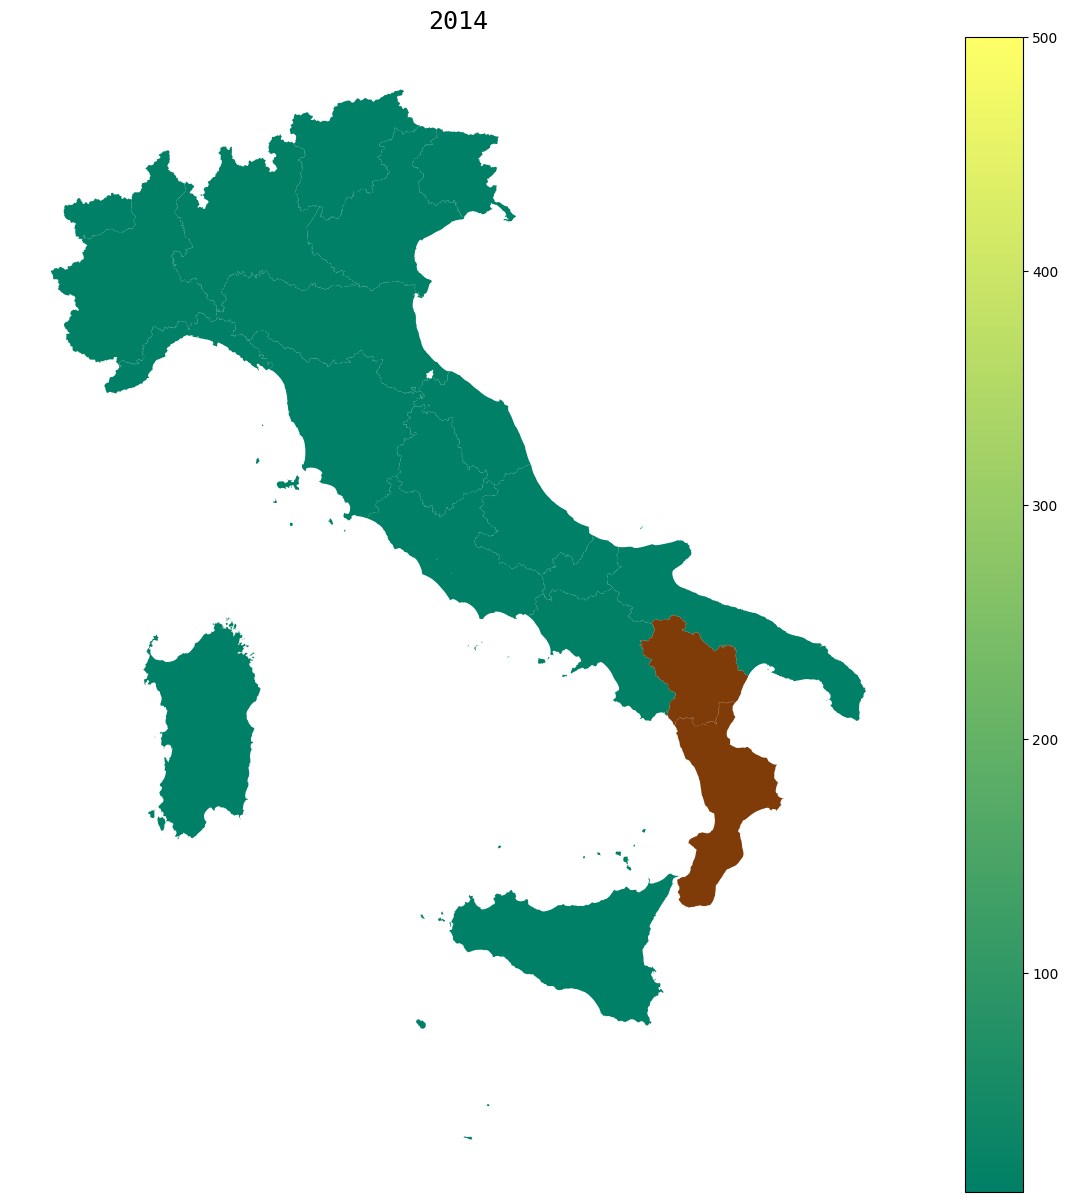

<Figure size 640x480 with 0 Axes>

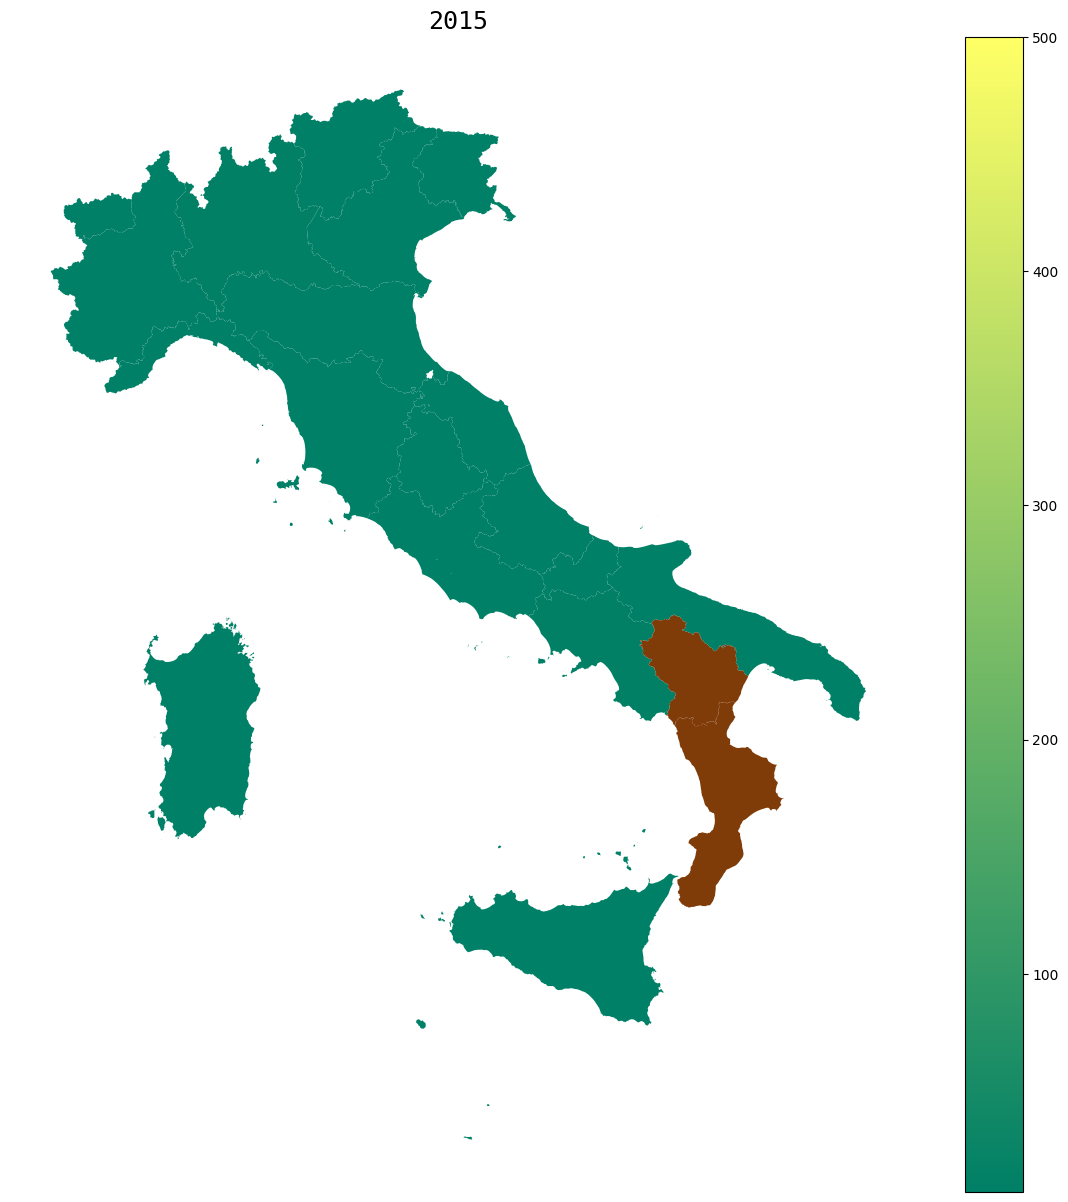

<Figure size 640x480 with 0 Axes>

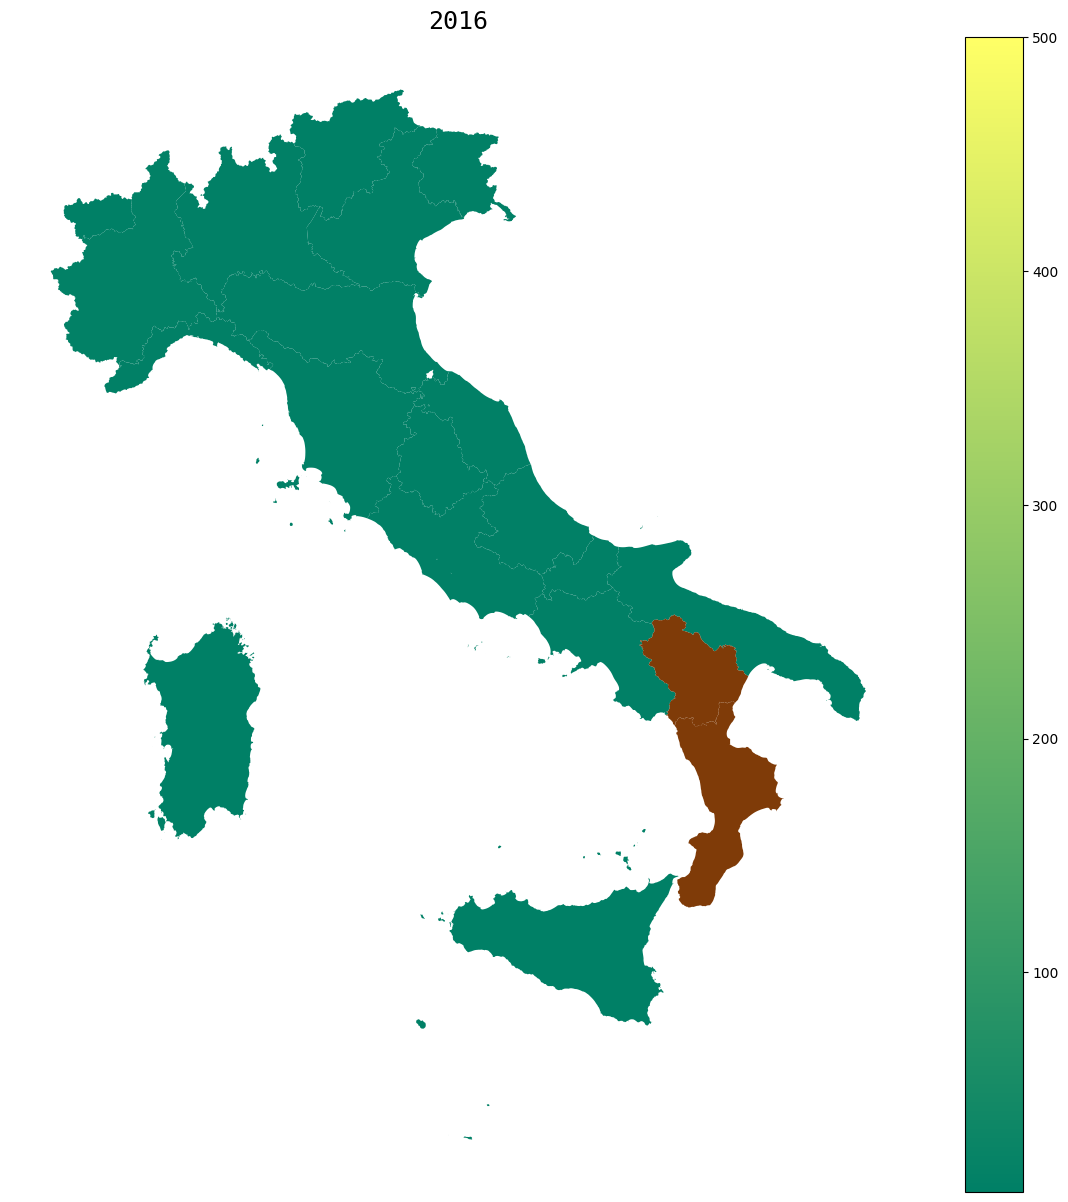

<Figure size 640x480 with 0 Axes>

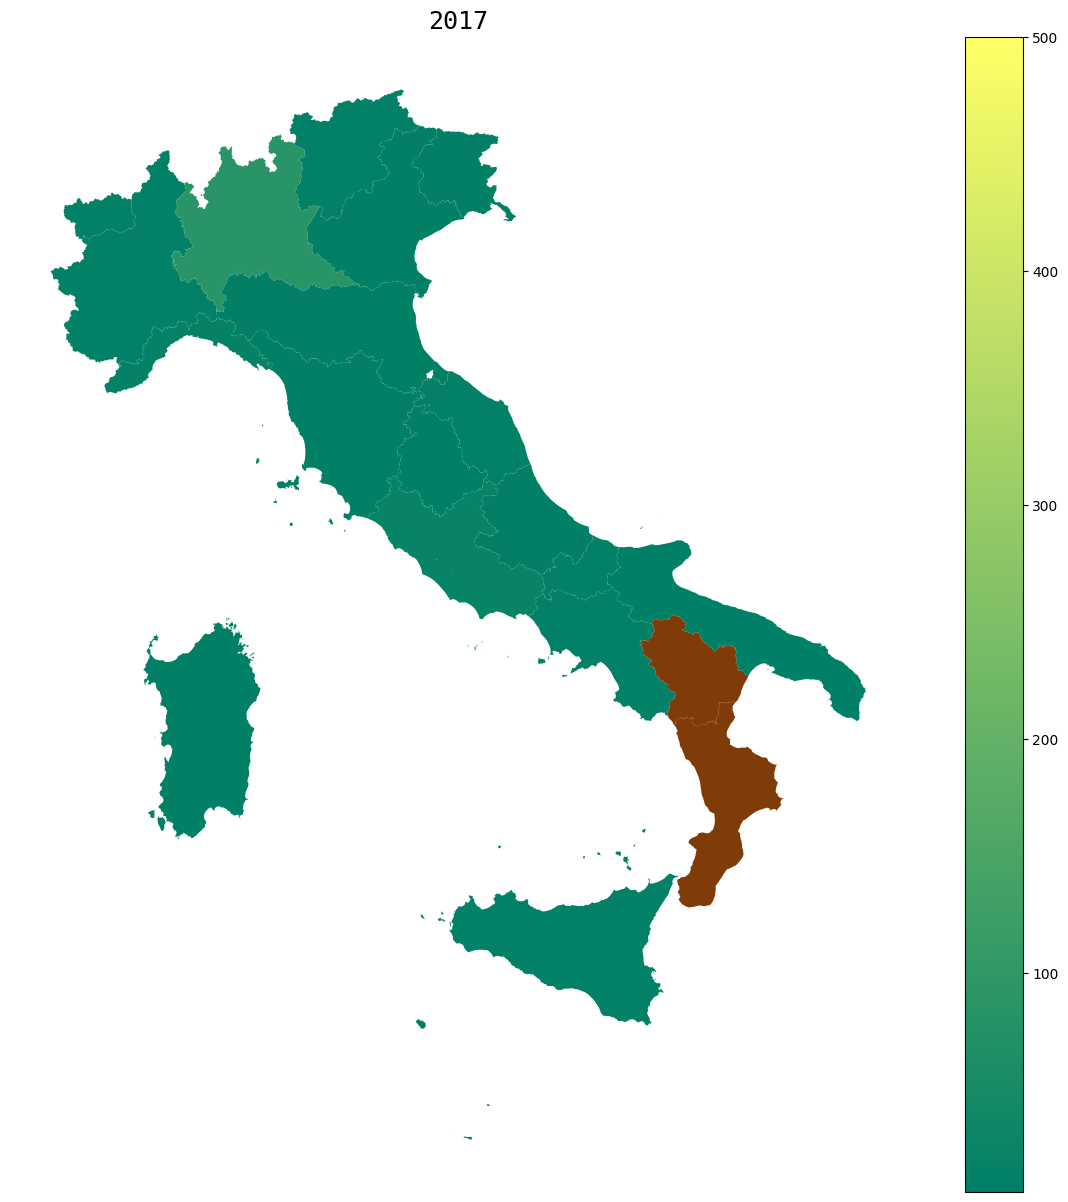

<Figure size 640x480 with 0 Axes>

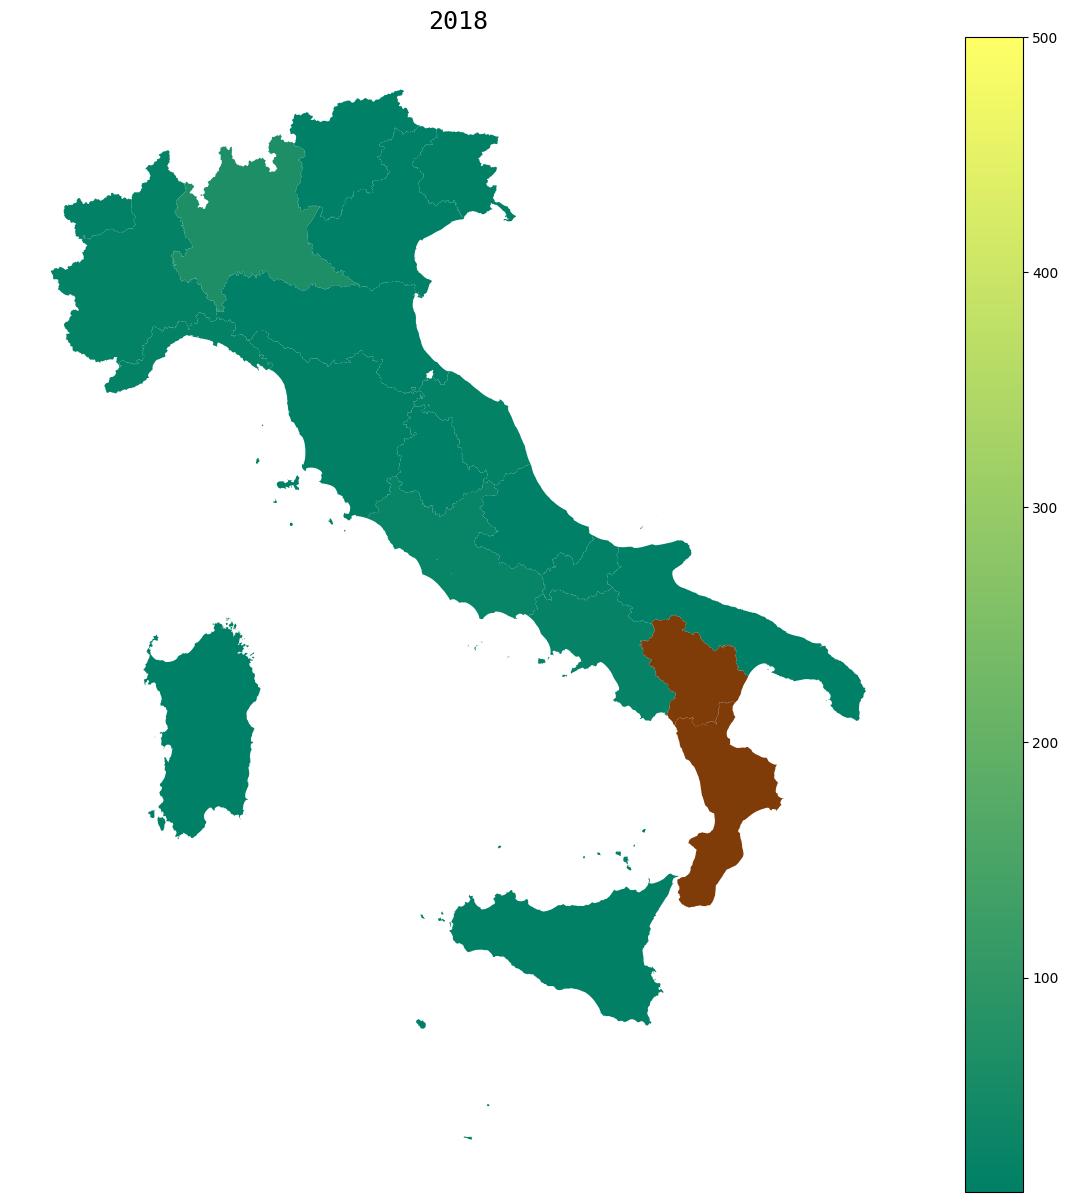

<Figure size 640x480 with 0 Axes>

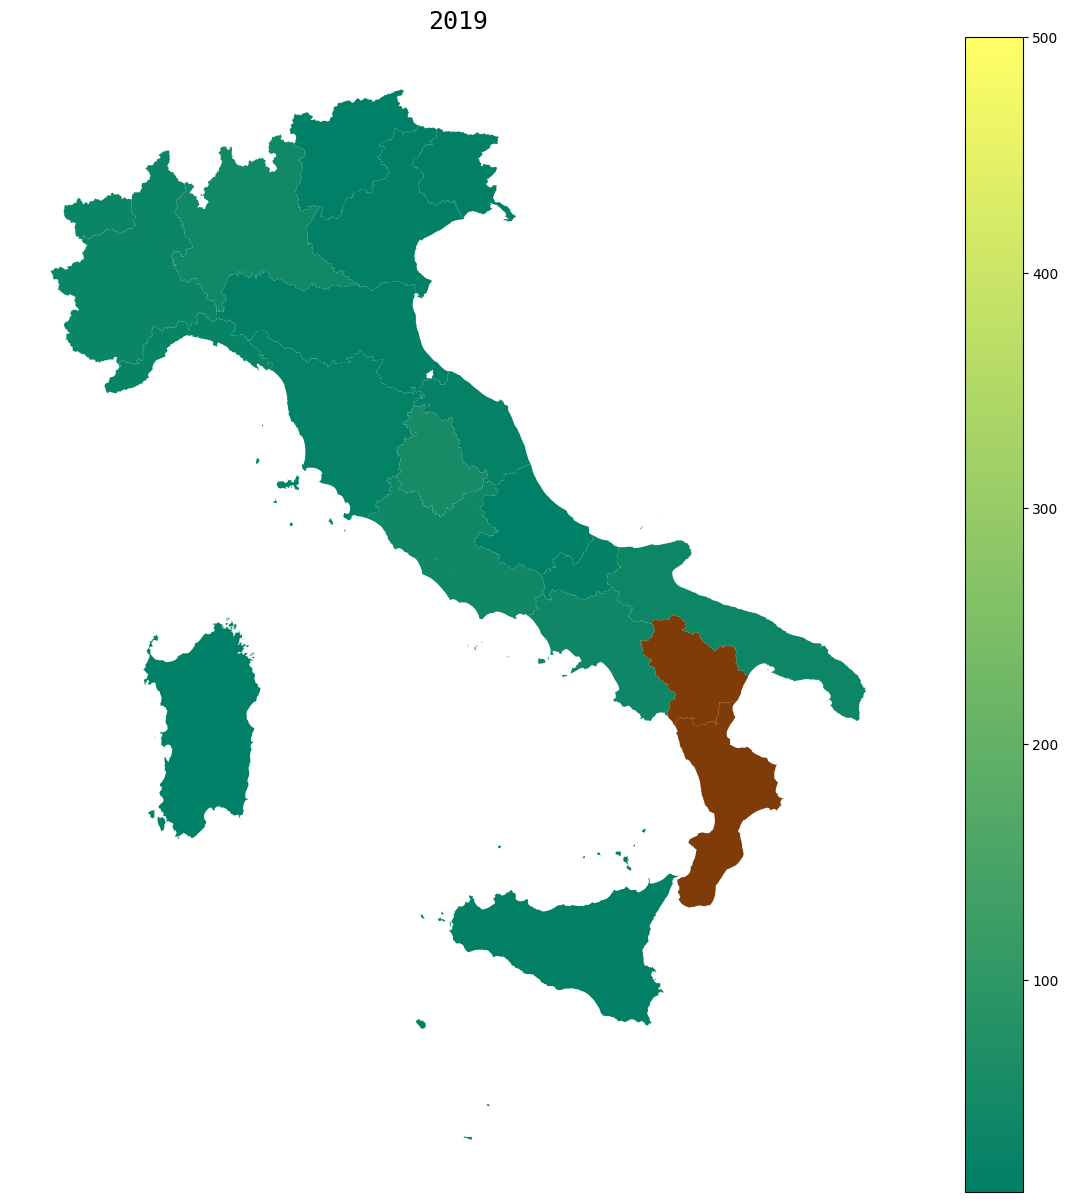

<Figure size 640x480 with 0 Axes>

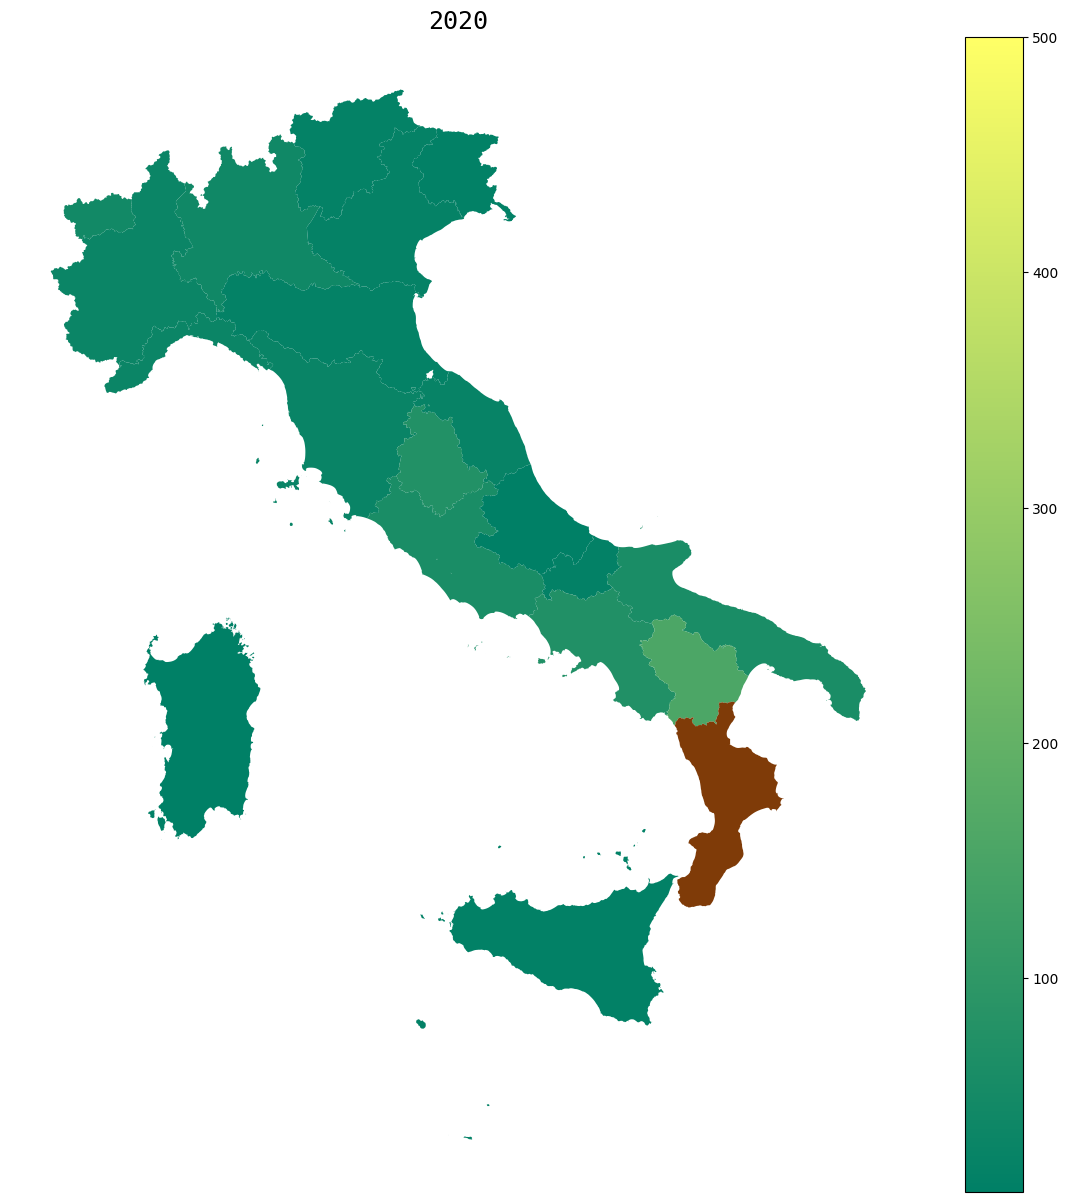

<Figure size 640x480 with 0 Axes>

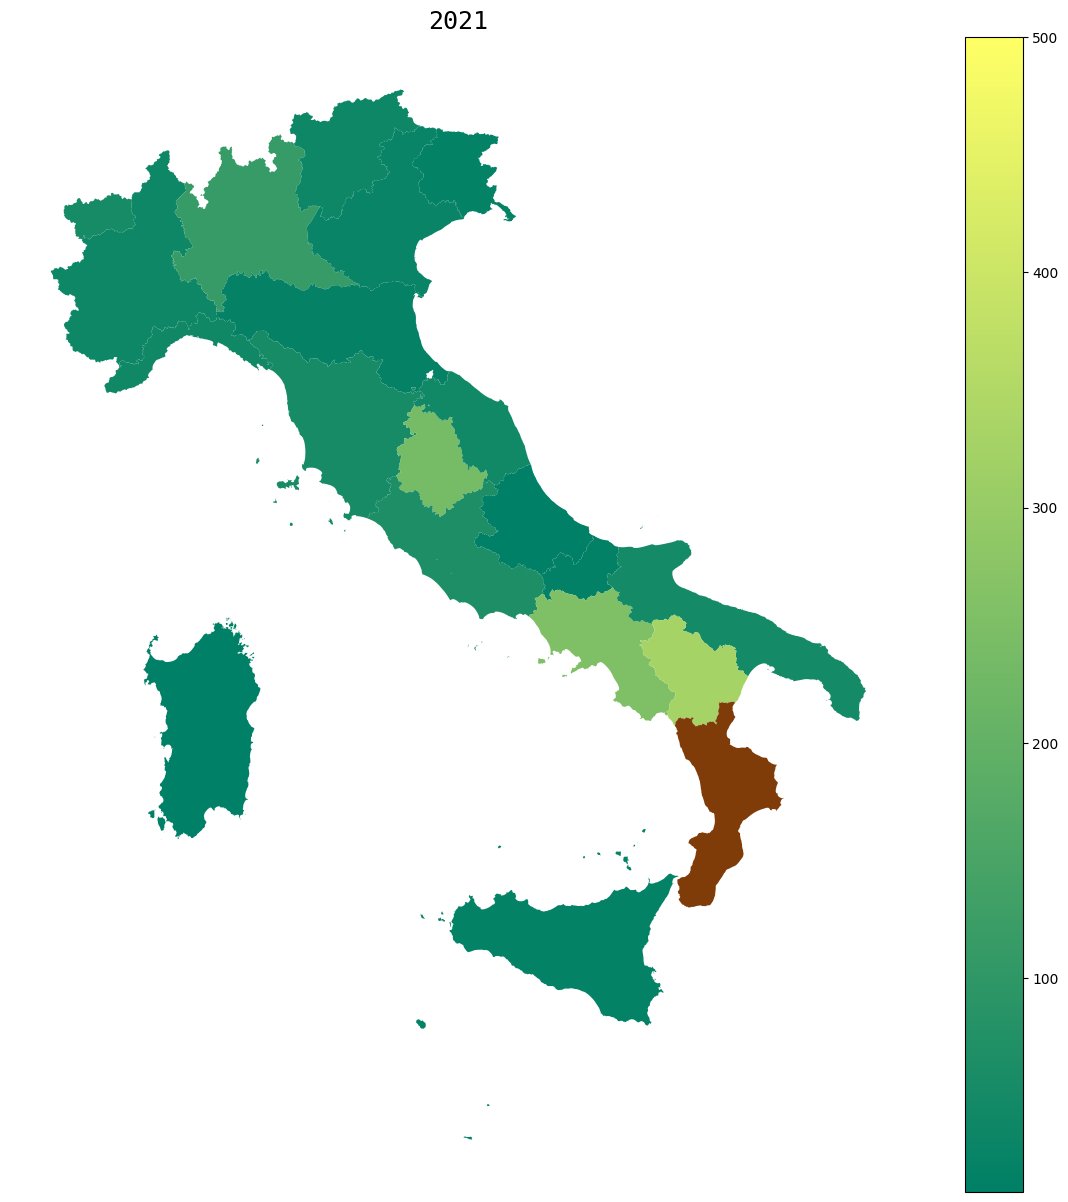

<Figure size 640x480 with 0 Axes>

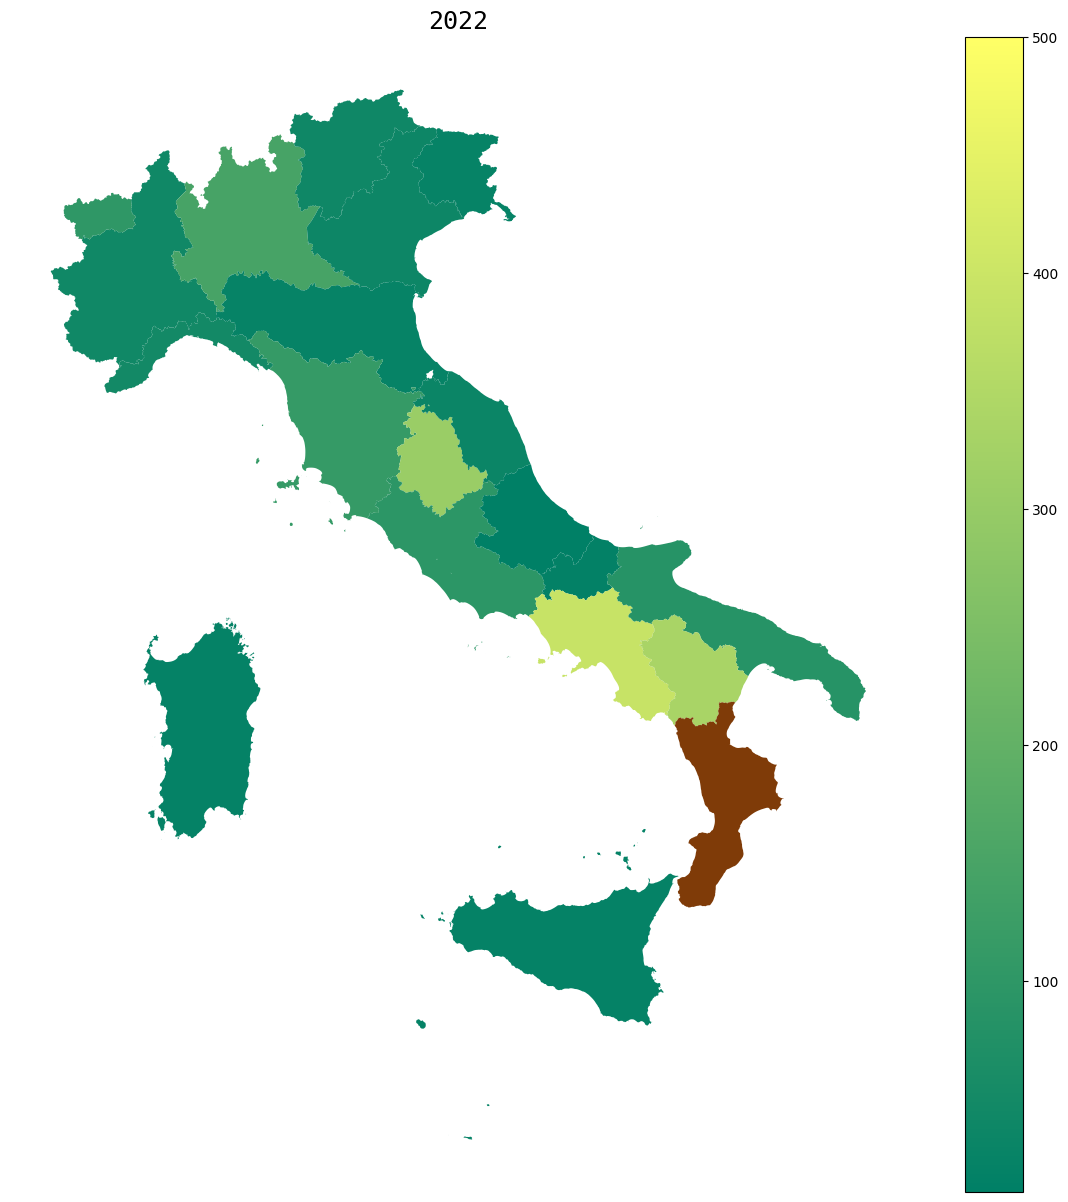

<Figure size 640x480 with 0 Axes>

In [11]:
f_path = "Dataset/dataset_all_2.csv"
df =  pd.read_csv(f_path)
df.Territorio = df.Territorio.replace(["Valled'Aosta"], 'Aosta' )
df.Territorio = df.Territorio.replace(["Trentino-AltoAdige"], 'Trentino' )
df.Territorio = df.Territorio.replace(["Friuli-VeneziaGiulia"], 'Friuli-Venezia Giulia' )
df_download_media = df[df.Tipo == "Download"]

m = []
for i in range(0, len(df_download_media)):
    m.append(float(re.findall("[-+]?(?:\d*\,*\d+)", df_download_media.iloc[i].Media)[0].replace(',','.')))

df_download_media["media_f"] = m
df_download_media.groupby(["Territorio","Anno"]).sum().reset_index()['Misure']

df_download_media_somma = df_download_media.groupby(["Territorio","Anno"]).sum().reset_index().drop(['Unnamed: 0','media_f'],axis = 1)

df_download_media_somma['misure_totali_anno'] = df_download_media_somma['Misure']
df_download_media_somma = df_download_media_somma.drop('Misure',axis = 1)
df_download_media = df_download_media.merge(df_download_media_somma, on=['Territorio','Anno'], how='left').reset_index()
df_download_media['media_f'] = df_download_media['media_f'] * df_download_media['Misure'] / df_download_media['misure_totali_anno']

df_download_media = df_download_media.drop(["Unnamed: 0","Profilo_x","Velocità (down/up)_x","Operatore_x","Periodo_x","Tipo_x","Media_x","Dev. Std._x","Min_x","Max_x","TP%_x"],axis = 1)
df_download_media = df_download_media.drop(["Profilo_y","Velocità (down/up)_y","Operatore_y","Periodo_y","Tipo_y","Media_y","Dev. Std._y","Min_y","Max_y","TP%_y"],axis = 1)
df_download_media = df_download_media.groupby(["Territorio","Anno"]).sum().reset_index()
df_download_media['NOME_REG'] = df_download_media['Territorio']
df_download_media = df_download_media.drop(['index','misure_totali_anno'],axis = 1)
merge = italy.merge(df_download_media[df_download_media["Anno"] == 2021], on='NOME_REG', how='left')

anni = df_download_media["Anno"].unique()
for anno in anni:
    merge = italy.merge(df_download_media[df_download_media["Anno"] == anno], on='NOME_REG', how='left')

    fig, ax = plt.subplots(1, figsize=(15, 15))
    ax.set_facecolor("white")
    col = 'media_f'
    merge.loc[20] = [0,'Artificial_min',0,0,None,None,0,0,0]
    merge.loc[20] = [0,'Artificial_max',0,0,None,None,0,0,500]
    ax.set_title(anno, fontdict={'fontsize':'18', 'fontweight':'2'}, color='Black', fontfamily='monospace')
    ax.set_axis_off()
    my_plot = merge.plot(ax=ax,
               column=col,
               cmap='summer',
               label='ciao',
               legend=True,
               categorical=False)
    #colore diverso per dati mancanti
    if anno < 2020:
        merge.loc[16,'media_f'] = 100
        
        my_plot = merge[merge.NOME_REG == 'Basilicata'].plot(
        ax=ax,
        column=col,
        cmap='PuOr',
        label='ciao',
        legend=False,
        categorical=True
    )
    merge.loc[17,'media_f'] = 100
    
    my_plot = merge[merge.NOME_REG == 'Calabria'].plot(
        ax=ax,
        column=col,
        cmap='PuOr',
        label='ciao',
        legend=False,
        categorical=True
    )
    fig = my_plot.get_figure()
    fig.savefig("italia_" + str(anno) +".png")
    plt.show()
    plt.clf()